### Supervised Learning Project: Identifying Potential Donors for CharityML

This project was part of Udacity's Machine Learning Nanodegree program.

In this project, multiple supervised learning algorithms were evaluated to build an effective model of individuals' income levels based on data from the 1994 U.S. Census. After an initial comparison of algorithms, the most promising model was further refined to maximize its accuracy in predicting whether an individual earns over $50,000 annually. This type of model is valuable in the non-profit sector, where understanding potential donors' income can guide organizations in making strategic decisions about donation requests. Although exact income details are often unavailable, these can be inferred from other publicly accessible data.

The dataset, sourced from the UCI Machine Learning Repository, was contributed by Ron Kohavi and Barry Becker and was originally presented in their research on a Naive-Bayes/Decision-Tree hybrid model. For this project, minor adjustments were made to the original data, such as removing the 'fnlwgt' feature and filtering out records with missing or inconsistent entries.

#### Data Exploration

To begin, we’ll import the necessary libraries, load the dataset, and conduct an initial examination of the data.

The 'income' column serves as our target label, indicating whether an individual earns more than or up to $50,000 per year. The remaining columns represent various features related to each individual in the census data.

In [3]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import visualisation libraries
import visuals as vs
import seaborn as sns
import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

from __future__ import division

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


A preliminary analysis of the dataset will reveal the distribution of individuals across the two income groups and provide insights into the percentage of those earning more than $50,000 annually.

We will examine the following metrics:

The total number of records, referred to as 'n_records'.
The count of individuals earning more than $50,000 per year, labeled 'n_greater_50k'.
The count of individuals earning at most $50,000 annually, denoted as 'n_at_most_50k'.
The percentage of individuals earning over $50,000, termed 'greater_percent'.

In [5]:
#Checking out the datatypes of the features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              45222 non-null  int64  
 1   workclass        45222 non-null  object 
 2   education_level  45222 non-null  object 
 3   education-num    45222 non-null  float64
 4   marital-status   45222 non-null  object 
 5   occupation       45222 non-null  object 
 6   relationship     45222 non-null  object 
 7   race             45222 non-null  object 
 8   sex              45222 non-null  object 
 9   capital-gain     45222 non-null  float64
 10  capital-loss     45222 non-null  float64
 11  hours-per-week   45222 non-null  float64
 12  native-country   45222 non-null  object 
 13  income           45222 non-null  object 
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


In [6]:
# Total number of records
n_records = len(data)

# Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data['income'] == '>50K'])

# Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data['income'] == '<=50K'])

# Percentage of individuals whose income is more than $50,000
greater_percent = 100 * n_greater_50k / n_records

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


We can also visualize how various individual features relate to income levels.

Let’s analyze the distribution of individuals earning above or below $50,000 based on their gender and education levels.

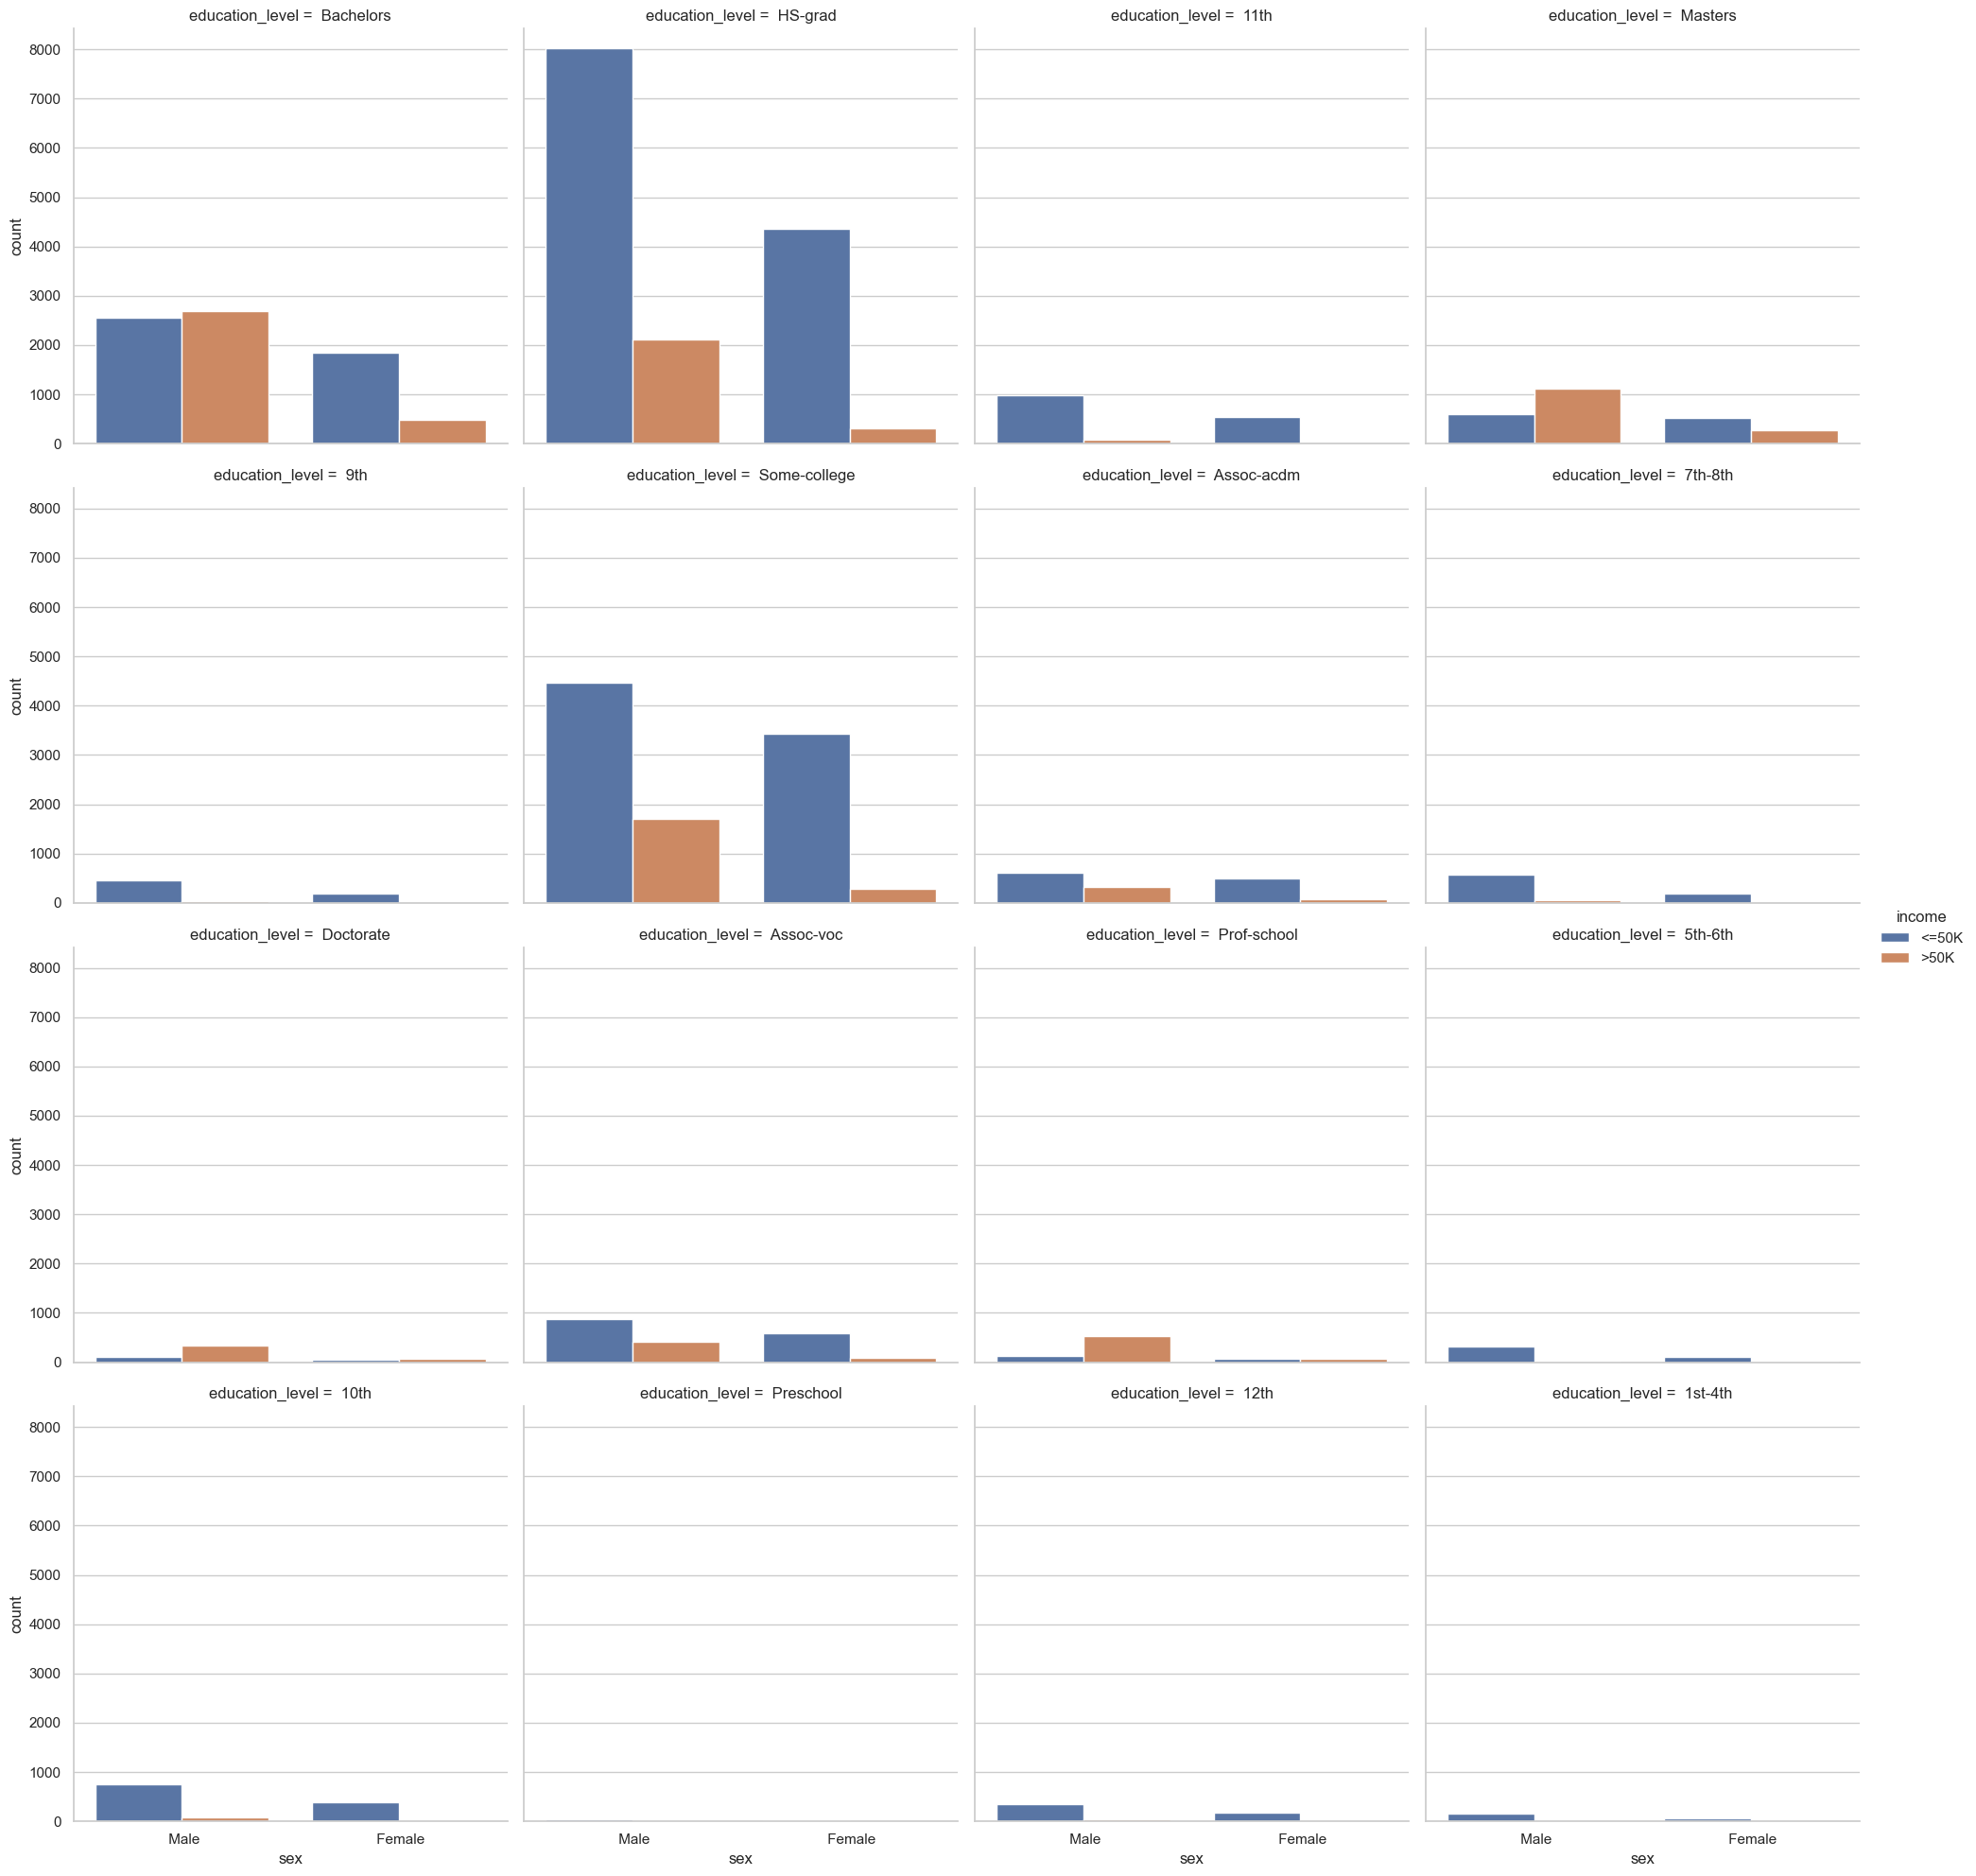

In [8]:
sns.set(style="whitegrid", color_codes=True)
sns.catplot(x="sex", col='education_level', data=data, hue='income', kind="count", col_wrap=4);

#### Data Preparation

Before the data can be utilized in machine learning algorithms, it often requires cleaning, formatting, and restructuring—commonly referred to as preprocessing. Fortunately, this dataset does not contain any invalid or missing entries. However, some characteristics of certain features need to be adjusted. Proper preprocessing can significantly enhance the performance and predictive capabilities of various learning algorithms.

#### Transforming Skewed Continuous Features

Sometimes, a dataset may include features where the values cluster around a single number, but also exhibit a substantial number of much larger or smaller values. Algorithms can be sensitive to these types of distributions and may not perform optimally if the range is not adequately normalized. In this census dataset, two features exhibit this behavior: 'capital-gain' and 'capital-loss'.

Let’s create histograms for these two features to examine their distributions.

In [10]:
import importlib
importlib.reload(vs)

<module 'visuals' from '/Users/diva/visuals.py'>

/Users/diva/visuals.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


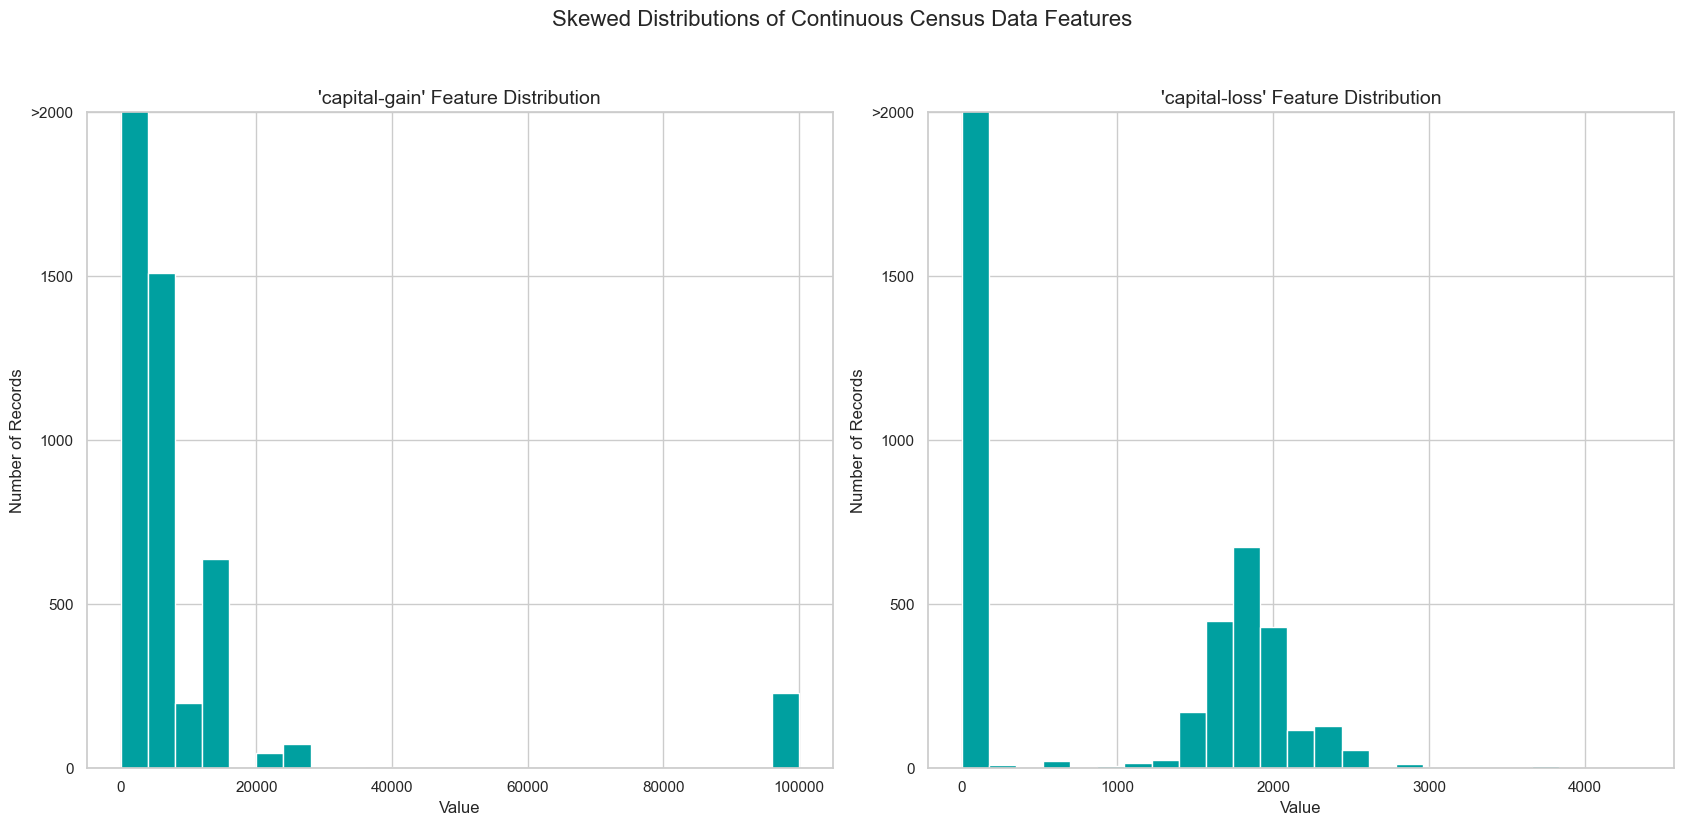

In [11]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For features with highly skewed distributions, such as 'capital-gain' and 'capital-loss', it is standard practice to apply a logarithmic transformation. This transformation helps mitigate the impact of extremely large or small values on the performance of learning algorithms. By using a logarithmic transformation, we can significantly reduce the range of values influenced by outliers.

/Users/diva/visuals.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


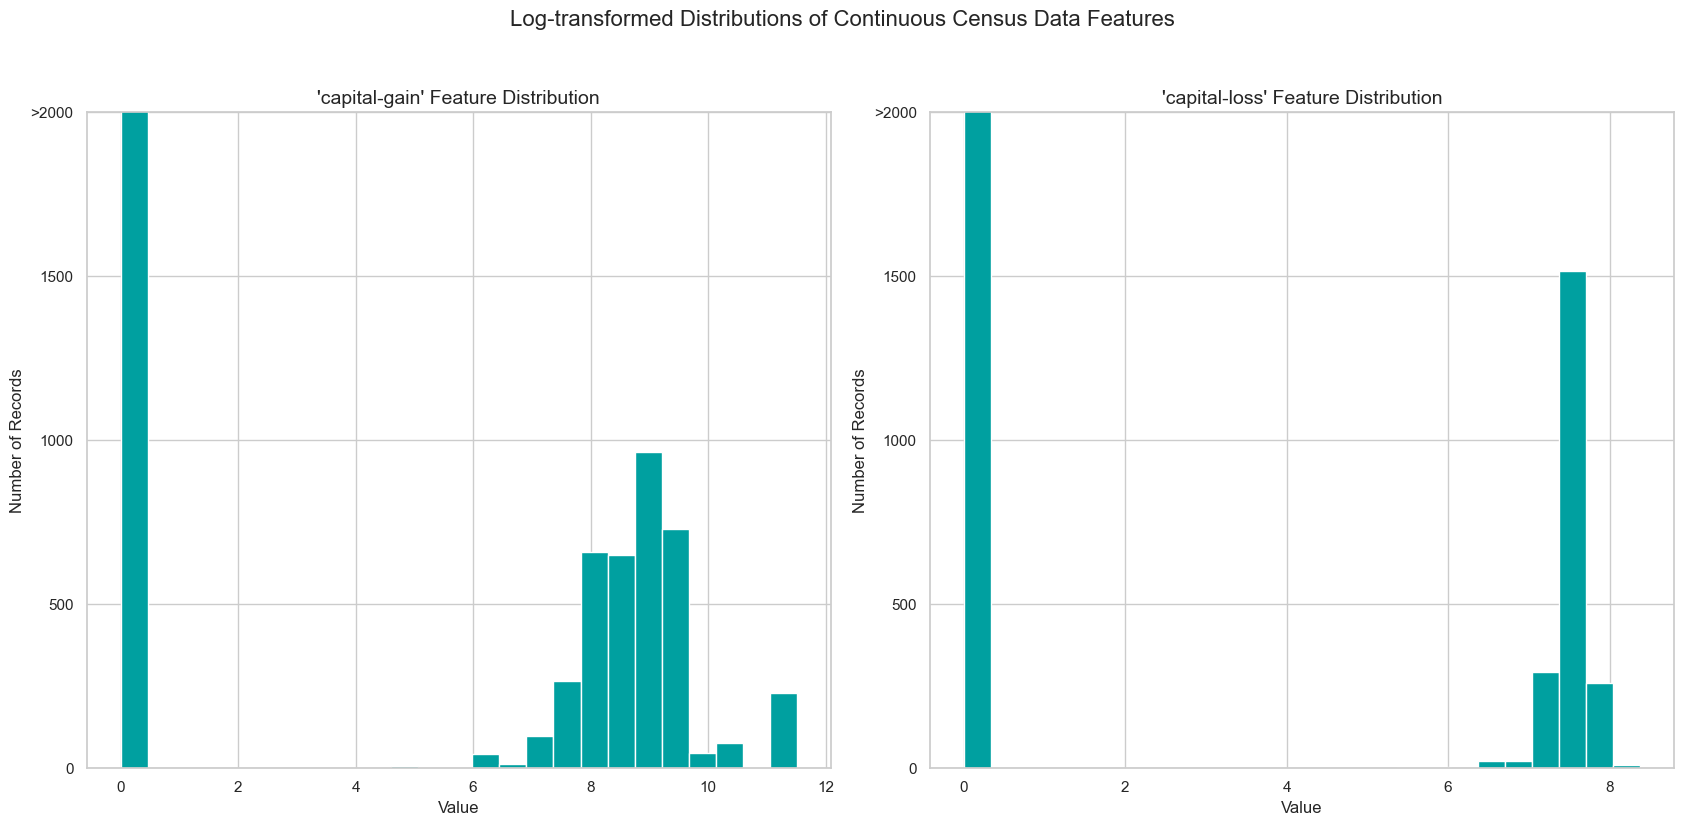

In [13]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

#### Normalizing Numerical Features

In addition to transforming highly skewed features, it is advisable to apply scaling to numerical features. Scaling does not alter the shape of each feature's distribution (as seen with 'capital-gain' or 'capital-loss'); however, normalization ensures that each feature is treated uniformly during the application of supervised learning algorithms. It's important to note that after scaling, the data in its raw form will no longer retain its original significance, as illustrated below.

In [15]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


#### Data Preprocessing

As observed in the table from the Data Exploration section, several features for each record are non-numeric. Typically, learning algorithms require numeric input, necessitating the conversion of these non-numeric features (known as categorical variables). A widely used method for this conversion is one-hot encoding, which generates a "dummy" variable for each potential category of each non-numeric feature.

Moreover, similar to the non-numeric features, we must also convert the non-numeric target label, 'income', into numerical values for the learning algorithm to function correctly. Since there are only two categories for this label ("<=50K" and ">50K"), we can simplify the process by encoding these categories as 0 and 1, respectively, instead of using one-hot encoding.

In [17]:
# One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 1 if x == '>50K' else 0)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names 
# print encoded
# Left uncommented due to output size

103 total features after one-hot encoding.


#### Shuffle and Split Data

With all categorical variables transformed into numerical features and the numerical features normalized, the next step is to split the data (including both features and labels) into training and test sets. We will allocate 80% of the data for training purposes and reserve 20% for testing.

In [19]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


#### Evaluating Model Performance

In this section, we will explore four different algorithms to identify the most effective model for our data.

#### Metrics and the Naive Predictor

CharityML's research indicates that individuals earning over 50,000 are more likely to donate to their cause. Consequently, the organization is particularly focused on accurately predicting who falls into this income bracket. While accuracy might seem like a suitable metric for evaluating model performance, it is crucial to consider the implications of misclassifying someone who earns less than 50,000 as a potential donor. For CharityML, accurately identifying individuals with incomes above $50,000 is more critical than merely recalling all individuals in that category. To assess this, we can utilize the F-beta score, which takes both precision and recall into account, with a specific emphasis on precision when 
β>1.

Considering the distribution of classes (those earning at most 50,000) is vital, as it can significantly influence accuracy. For instance, we could naively claim that "no one makes more than 50,000" and still achieve a high accuracy rate without analyzing the actual data. Such a naive prediction fails to utilize any meaningful information and serves only as a baseline benchmark to determine whether our model is performing effectively. However, relying solely on this prediction would be counterproductive, as predicting that everyone earns less than 50,000 would mean CharityML would fail to identify any potential donors.

#### Naive Predictor Performance

What would happen if we selected a model that consistently predicted that every individual earns more than $50,000? We need to evaluate this model's accuracy and F-score based on the dataset.

In [22]:
# Calculate accuracy
accuracy = n_greater_50k / n_records

# Calculating precision
precision = n_greater_50k / (n_greater_50k + n_at_most_50k)

#Calculating recall
recall = n_greater_50k / (n_greater_50k + 0)

# Calculate F-score using the formula above for beta = 0.5
fscore =  (1  + (0.5*0.5)) * ( precision * recall / (( 0.5*0.5 * (precision))+ recall))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


#### Supervised Learning Models

#### Model Application

We will select three appropriate supervised learning models from the list above and evaluate their performance on the census data.

#### Decision Trees

Real-World Application: Decision Trees, and more broadly CART (Classification and Regression Trees), are commonly used in financial analysis. For example, they can predict which stocks to buy based on past performance.

Strengths:

- Capable of handling both categorical and numerical data.
- Requires minimal data preprocessing and can work with unnormalized or unencoded data.
- Simple to understand and interpret.

Weaknesses:

- Complex Decision Trees can overfit the data and do not generalize well.
- They can be unstable, with small changes in data leading to different tree structures. As a result, they are often used in ensembles (like Random Forests) to enhance robustness.
- May produce biased trees if certain classes dominate.
- 
Candidacy: Decision Trees are suitable for our case since they can handle both numerical and categorical data, and the preprocessing steps may reduce any advantages they might have. Their interpretability also allows us to understand the decision-making process.

#### Support Vector Machines (SVM)

Real-World Application: SVMs are frequently used for image classification and segmentation, such as face detection in images.

Strengths:

- Effective in high-dimensional spaces, especially with many features.
- Kernel functions allow adaptation to various cases and can be customized as needed, making SVMs versatile.

Weaknesses:

- Not well-suited for large datasets.
- Does not provide direct probability estimates.

Candidacy: SVMs are chosen for their effectiveness in high-dimensional settings. With over 100 features in our dataset due to dummy variables, SVMs are expected to perform well. Additionally, the size of our dataset is manageable.

#### Ensemble Methods: AdaBoost

Real-World Application: Ensemble methods are widely used in Kaggle competitions, particularly in image detection. For example, Adaboost can be used for object detection, such as identifying players in a basketball game.

Strengths:

- Ensemble methods like Adaboost are more robust than individual estimators and offer improved generalizability.
- They allow for the combination of simple models to create a complex model that is computationally efficient.

Weaknesses:

- If the underlying classifier is biased, it can lead to a biased boosted model.

Candidacy: Ensemble methods are recognized as high-quality classifiers, and Adaboost is one of the most popular boosting algorithms. Given the class imbalance in our dataset, boosting may enhance robustness.

#### Creating a Training and Prediction Pipeline

To effectively evaluate each selected model's performance, it is essential to establish a training and prediction pipeline. This pipeline will enable efficient training of models with various training data sizes and facilitate predictions on the test data.

In [24]:
# Import two metrics from sklearn - fbeta_score and accuracy_score

from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,beta=0.5)
        
    # Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

#### Model Evaluation

We will train and test the models using training sets of varying sizes to assess how this impacts their runtime and predictive performance on both the training and test sets.

DecisionTreeClassifier trained on 362 samples.
DecisionTreeClassifier trained on 3618 samples.
DecisionTreeClassifier trained on 36177 samples.
SVC trained on 362 samples.
SVC trained on 3618 samples.
SVC trained on 36177 samples.
AdaBoostClassifier trained on 362 samples.


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier trained on 3618 samples.


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier trained on 36177 samples.


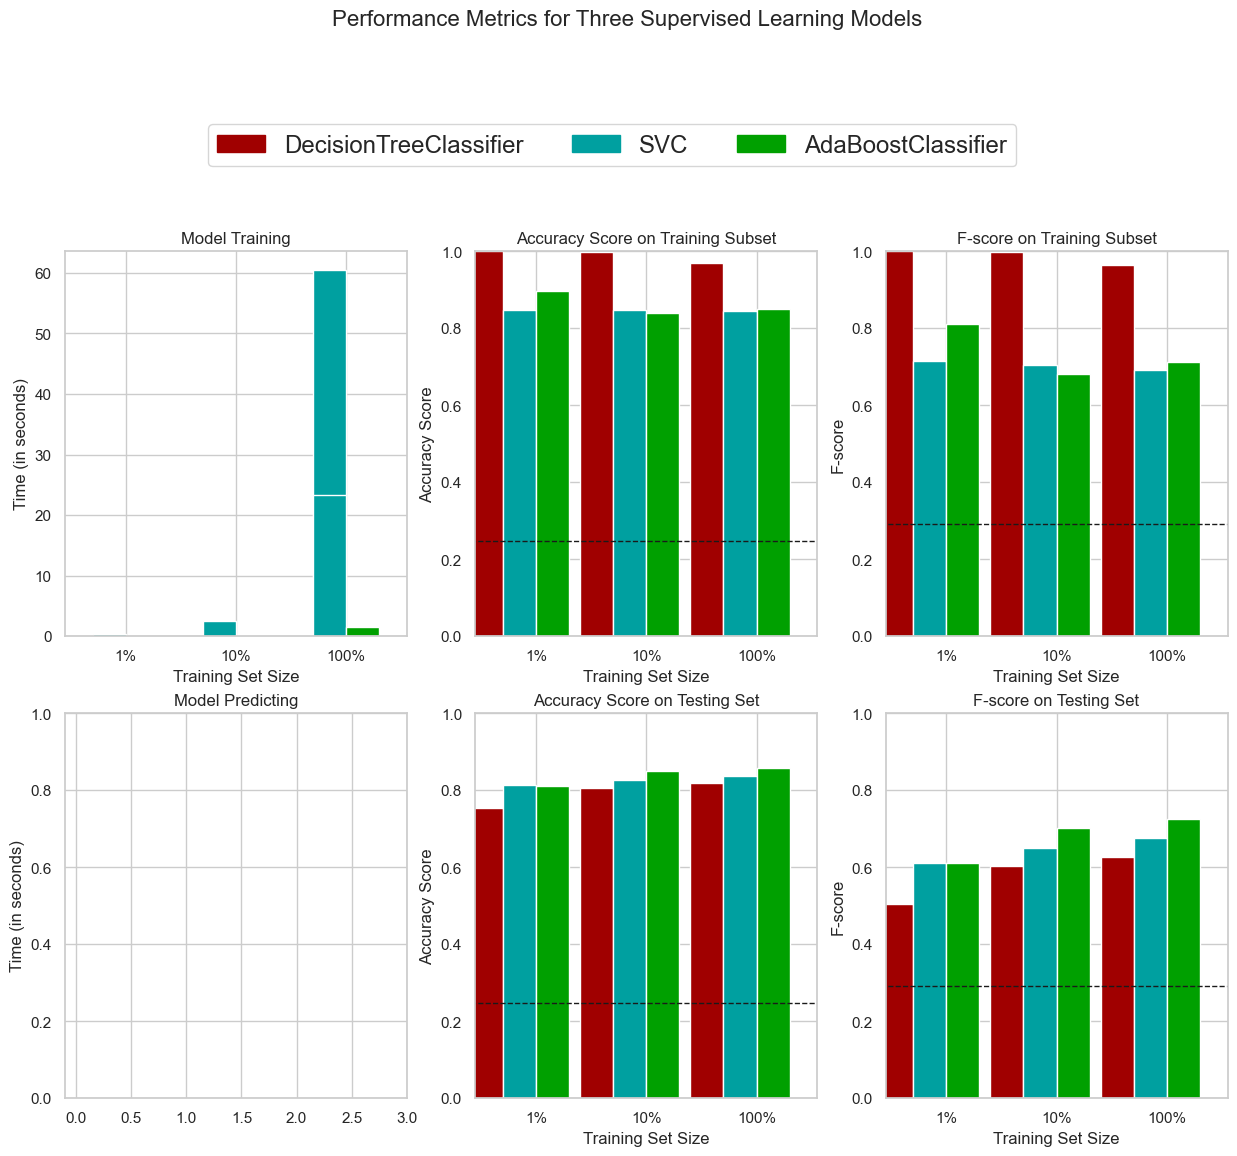

In [26]:
# Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

# Initialize the three models, the random states are set to 101 so we know how to reproduce the model later
clf_A = DecisionTreeClassifier(random_state=101)
clf_B = SVC(random_state = 101)
clf_C = AdaBoostClassifier(random_state = 101)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(round(len(X_train) / 100))
samples_10 = int(round(len(X_train) / 10))
samples_100 = len(X_train)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

We can also print out the values in the visualizations above to examine the results in more detail.

In [28]:
#Printing out the values
for i in results.items():
    print(i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

DecisionTreeClassifier


,1%,10%,100%
train_time,0.003215,0.023388,0.273957
pred_time,0.003495,0.004213,0.004954
acc_train,1.000000,0.996667,0.970000
acc_test,0.754008,0.806081,0.817468
f_train,1.000000,0.997191,0.963855
f_test,0.505562,0.602673,0.625637


SVC


,1%,10%,100%
train_time,0.007953,0.472990,60.561063
pred_time,0.321399,2.488126,23.353771
acc_train,0.846667,0.846667,0.843333
acc_test,0.812825,0.826645,0.837148
f_train,0.714286,0.703125,0.690299
f_test,0.610597,0.650518,0.674826


AdaBoostClassifier


,1%,10%,100%
train_time,0.051593,0.165064,1.595382
pred_time,0.083949,0.064638,0.065782
acc_train,0.896667,0.840000,0.850000
acc_test,0.810392,0.849862,0.857601
f_train,0.811688,0.680147,0.711538
f_test,0.610473,0.701882,0.724551


And visualize the confusion matrix for the results.

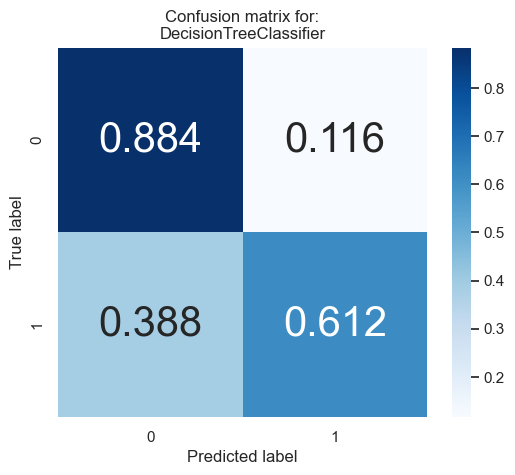

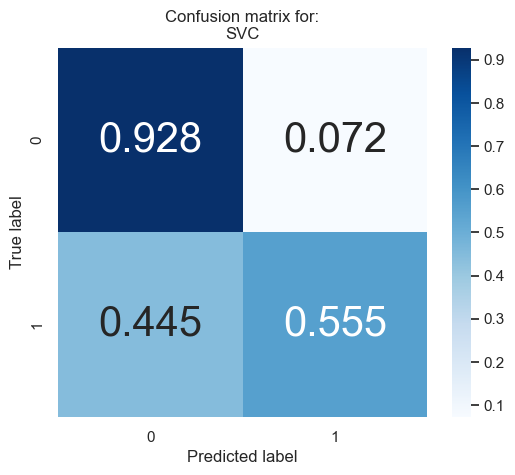

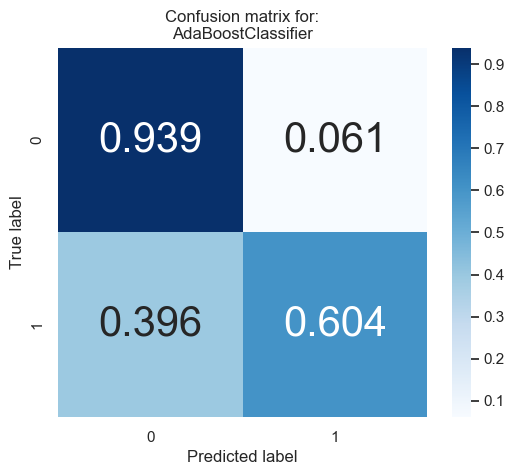

In [30]:
#Visualizing the confusion matrix for each classifier
from sklearn.metrics import confusion_matrix

for i,model in enumerate([clf_A,clf_B,clf_C]):
    cm = confusion_matrix(y_test, model.predict(X_test))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

    # view with a heatmap
    plt.figure(i)
    sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));

#### Model Evaluation

Based on the results, AdaBoost is the most suitable model for our task among the three evaluated.

Firstly, it outperforms the others in terms of both accuracy and F-score on the testing data. Additionally, it trains on the full dataset in a reasonable amount of time—just a fraction of the 120 seconds required by SVM, the next best-performing classifier. This suggests that AdaBoost will scale effectively with larger datasets.

By default, AdaBoost utilizes a decision stump, which is a decision tree of depth 1, as its base classifier, capable of handling both categorical and numerical data. Since weak learners are generally quicker to train, the size of the dataset is not a concern for this algorithm.

#### How Does AdaBoost Work?

AdaBoost operates by combining multiple simple learners (e.g., decision trees) to form an ensemble that predicts whether an individual earns more than $50,000.

Each learner, in this case, decision trees, utilizes the "features" we have about individuals (such as age, occupation, education, etc.) to establish a set of rules for predicting income.

During the training phase, which occurs over several rounds, the AdaBoost algorithm focuses on instances where it previously made incorrect predictions, prioritizing these in the next training round.

With each iteration, the model identifies the best learner (or decision tree) to add to the ensemble, repeating this process for a specified number of rounds or until further improvements are no longer possible.

Ultimately, all learners contribute to the final ensemble model, with each one casting a vote to predict if a person earns more than $50,000. The final prediction is typically based on the majority of the votes.

By applying this model to the census data of individuals, we can forecast similar information for potential new donors and assess the likelihood of their contributions to charity.

#### Improving Our Model: Model Tuning

To enhance our results, we can use grid search (GridSearchCV) to tune our model with various parameter combinations.

For AdaBoost, we will adjust the **n_estimators** and **learning rate** parameters, along with the parameters of the base classifier (which, as a reminder, is a decision tree for the AdaBoost ensemble).

In [33]:
# Import necessary libraries
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Initialize the classifier with the SAMME algorithm to avoid the warning
clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(), algorithm="SAMME")

# Create the parameters list you wish to tune
parameters = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.5],
    'estimator__min_samples_split': [2, 4],
    'estimator__max_depth': [1, 2]
}

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform randomized search on the classifier using 'scorer' as the scoring method
random_search = RandomizedSearchCV(estimator=clf, param_distributions=parameters, n_iter=10, scoring=scorer)
random_search.fit(X_train, y_train)

# Get the best estimator
best_clf = random_search.best_estimator_

# Make predictions using the optimized model
best_predictions = best_clf.predict(X_test)

# Report the final scores
print("Optimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta=0.5)))
print(best_clf)


Optimized Model
------
Final accuracy score on the testing data: 0.8499
Final F-score on the testing data: 0.7133
AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=100)


#### Feature Importance

A critical task in supervised learning, particularly with the census data we are analyzing, is to identify which features offer the most predictive power. By concentrating on a few key features related to our target label, we can simplify our understanding of the data, which is typically beneficial. In this project, our goal is to pinpoint the features that most significantly predict whether an individual earns more than or at most $50,000.

#### Feature Relevance Observation

We have thirteen features available for each individual in the census dataset. Based on my insights, here are five features that I believe are most crucial for making predictions:

Occupation: Different occupations come with varying pay scales, leading to significant differences in earnings.

Education: Individuals with higher education levels are often better positioned for technical or specialized jobs that offer higher salaries.

Age: Generally, as individuals age, they accumulate more wealth and experience, which can translate into higher earnings.

Work Class: The type of work class an individual belongs to can also correlate with their income level.

Hours per Week: Typically, those who work more hours per week are likely to earn more.

These features are ranked based on my assessment of their impact on an individual’s income, with occupation ranked highest due to the variability in pay across different jobs. Higher education is also crucial, as it generally leads to better earning potential.

Now, let’s analyze how our algorithm assesses the importance of these features.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


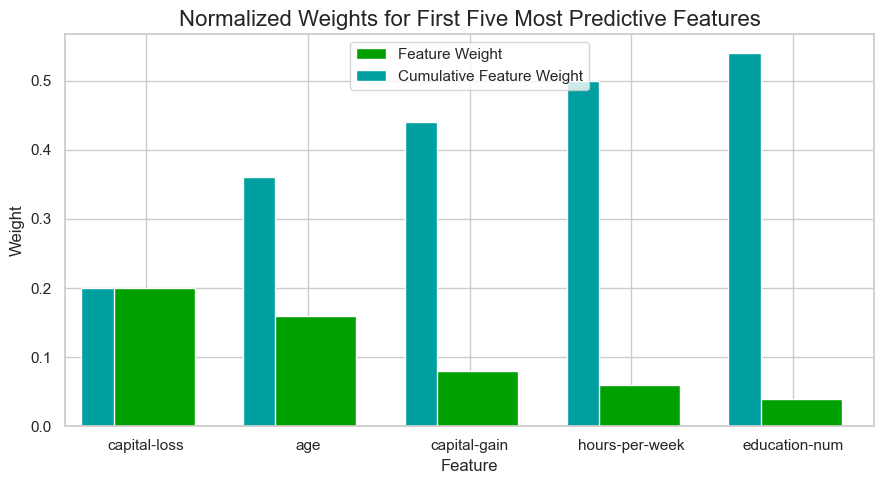

In [36]:
# Import a supervised learning model that has 'feature_importances_'

# Train the supervised model on the training set 
model = AdaBoostClassifier().fit(X_train,y_train)

# Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

Of the five features predicted in the earlier section, 3 of them, Age, hours per week, education-num (which is a numerical label for education) are included in the list of features considered most important by Adaboost, although with different rankings.

I didn't consider two important features, capital-gain and capital-loss, partly due to my lack of understanding of what they meant. After researching what they mean (profit or loss from on the sale of assets/property), it makes sense for these features to be important. People who have earned profits from sale of assets are definitely likelier to earn higher, while those who incurred losses are likely to have had lower total income.

Feature Selection

An interesting question here is, how does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of all features present in the data. This hints that we can attempt to reduce the feature space and simplify the information required for the model to learn.

Let's see how a model that is trained only on the selected features, performs.

In [39]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8499
F-score on testing data: 0.7133

Final Model trained on reduced data
------
Accuracy on testing data: 0.8238
F-score on testing data: 0.6478


Effects of Feature Selection

On a reduced dataset, the final model's accuracy and f-score are still very comparable to the results on the full dataset.

The acccuracy is ~2.7% lower, while the f-score is ~5% lower. Even though Adaboost is relatively faster than one of the other classifiers that we tried out, I'd still consider training on the reduced data (acc. to features) if training time was a factor, and we have more training points to process. This decision will also depend on how important accuracy and f-scores are (or if f-score is more important than the accuracy, as the dip for that is larger than the dip in accuracy), to make a final decision regarding this.